In [1]:
# Imports
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import json
import time
from collections import defaultdict

In [2]:
def setup_webdriver(width=800, height=600):
    """Opens a chrome window and sets the size of the window. The webdriver object is returned."""
    driver = webdriver.Chrome()
    driver.set_window_size(width, height, windowHandle='current')
    time.sleep(1)
    return driver

**This function should do the following:**
1. Find the number of rooms returned by the given min/max values
2. If the number of rooms is greater than 300 then reduce the max until a number of rooms less than 300 is return
3. Maximize the number of rooms returned such that the number of rooms returned is the largest amount less than 300

In [13]:
def find_room_count_for_range(url, driver, min_price=0, max_price=10):
    """Requests Airbnb listings and searches for the price range that yields the greatest number
    of stays that is less than 300. The price range is returned as a tuple. The function adds $20
    until it exceeds 299 stays. The function will do a binary search for the lowest price that will yield
    the greatest number of stays that is less than 300.
    
    Inputs:
        min_price: The minimum price to consider.
    Outputs
        (min, max) tuple. A tuple containing the minimum and maximum price range."""
    
    offset = 0
    
    # Occasionally Airbnb will not return the room count data and the BeautifulSoup selector will return
    # an empty list. The following loop will relaod the page until the room counts are returned. It will
    # try 5 times.
    for i in range(5):
        try:
            driver.get(url.format(min_price, max_price, offset))
            time.sleep(5)
            soup = BeautifulSoup(driver.page_source)
            room_count = soup.select('div._1snxcqc')[0].string.split()[0]
            room_count.replace('+', '')
            room_count = int(room_count.replace('+', ''))
            break
        except:
            pass
    
    return room_count
driver = setup_webdriver(1730, 1020)
url = 'https://www.airbnb.com/s/Bogota--Colombia/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&place_id=ChIJKcumLf2bP44RFDmjIFVjnSM&source=structured_search_input_header&search_type=pagination&federated_search_session_id=43bfeb76-6669-4ea0-9fca-ad6e6789fb2a&query=Bogota%2C%20Colombia&checkin=2020-07-12&checkout=2020-07-15&price_min={}&price_max={}&room_types%5B%5D=Entire%20home%2Fapt&section_offset=4&items_offset={}'
print(find_room_count_for_range(url, driver, max_price=16))
# time.sleep(7)
driver.close()

237


In [17]:
def find_optimum_range(url, driver, min_price=0, max_price=20):
    """Finds the optimum praice range to get less than 300 stays.
    
    This function will:
    1. Get the number of rooms at the given price range.
    2. If more than 300 rooms are returned it will decrease the max_price until a value less than 300 rooms is returned.
    3. If less than 300 rooms are returned it will increase the max_price until more than 300 rooms are returned.
    4. Steps 2 & 3 will be repeated until a price range that will yield the largest number of rooms less than 300 is found."""
    
    top = max_price + 500
    bottom = min_price
    room_count = find_room_count_for_range(url, driver, min_price, max_price)
    
    while(room_count >= 300 or (top > max_price + 1 and room_count > 0)):
        if room_count >= 300:
            top = max_price
            max_price = bottom + (max_price - bottom) // 2
        else:
            bottom = max_price
            max_price = max_price + (top - max_price) // 2
        room_count = find_room_count_for_range(url, driver, min_price, max_price)
    
    return (room_count, min_price, max_price)
            

driver = setup_webdriver(1730, 1020)
url = 'https://www.airbnb.com/s/Bogota--Colombia/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&place_id=ChIJKcumLf2bP44RFDmjIFVjnSM&source=structured_search_input_header&search_type=pagination&federated_search_session_id=43bfeb76-6669-4ea0-9fca-ad6e6789fb2a&query=Bogota%2C%20Colombia&checkin=2020-07-12&checkout=2020-07-15&price_min={}&price_max={}&room_types%5B%5D=Entire%20home%2Fapt&section_offset=4&items_offset={}'
print(find_optimum_range(url, driver, 0, 100))
driver.close()

(237, 0, 16)


In [18]:
def get_price_ranges(url, driver, min_price=0, max_price=0):
    price_ranges = []
    last_count = 1
    while(last_count > 0):
        current_range = find_optimum_range(url, driver, min_price, max_price)
        if current_range[0] > 0:
            price_ranges.append(current_range)
            min_price = current_range[2] + 1
            max_price = current_range[2] + 1
        last_count = current_range[0]
    
    return price_ranges
driver = setup_webdriver(1730, 1020)
url = 'https://www.airbnb.com/s/Bogota--Colombia/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&place_id=ChIJKcumLf2bP44RFDmjIFVjnSM&source=structured_search_input_header&search_type=pagination&federated_search_session_id=43bfeb76-6669-4ea0-9fca-ad6e6789fb2a&query=Bogota%2C%20Colombia&checkin=2020-07-12&checkout=2020-07-15&price_min={}&price_max={}&room_types%5B%5D=Entire%20home%2Fapt&section_offset=4&items_offset={}'
print(get_price_ranges(url, driver, 0, 100))
driver.close()

[(237, 0, 16), (255, 17, 20), (254, 21, 24), (249, 25, 28), (192, 29, 32), (244, 33, 37), (278, 38, 43), (279, 44, 51), (297, 52, 67), (278, 68, 99), (292, 100, 599), (5, 600, 1099)]


In [3]:
def get_cleaning_fee(price_item_list):
    """Applies a filter to get the pricing item that is the cleaning."""
    def cleaning_fee_filter(item):
        return item['localizedTitle'] == 'Cleaning fee'
    cleaning_fee_item = list(filter(cleaning_fee_filter, price_item_list))
    if cleaning_fee_item:
        return cleaning_fee_item[0]['total']['amount']
    else:
        return 0
                             
# stays[0]['pricingQuote']['price']['priceItems']))[0]['total']['amount']

In [18]:
def get_listings(driver, url):
    driver.switch_to.window(driver.window_handles[0])
    stays_added = 0
    seen_ids = set()
    keep_looping = True
    offset = 0
    stay_dict = defaultdict(list)
    dup_dict = defaultdict(list)
    while keep_looping:
        stays_added = 0
        min_price = 0
        max_price = 20
        driver.get(url.format(min_price, max_price, offset))
        time.sleep(5)
        soup = BeautifulSoup(driver.page_source)
        json_dict = soup.select('script#data-state')
        listings = json.loads(json_dict[0].string)
        stays = listings['niobeClientData']['__niobe_denormalized']['queries'][0][1]['dora']['exploreV3']['sections'][0]['items']
        for stay in stays:
            current_id = stay['listing']['id']
            if current_id in seen_ids:
#                 print('Duplicate ID:', current_id)
                dup_dict['sid'].append(stay['listing']['id'])
                dup_dict['guests'].append(stay['listing']['personCapacity'])
                dup_dict['bedrooms'].append(stay['listing']['bedrooms'])
                dup_dict['beds'].append(stay['listing']['beds'])
                dup_dict['bathrooms'].append(stay['listing']['bathrooms'])
                dup_dict['amenities'].append(stay['listing']['amenityIds'])
                dup_dict['superhost'].append(stay['listing']['isSuperhost'])
                dup_dict['starRating'].append(stay['listing']['avgRating'])
                dup_dict['amount'].append(stay['pricingQuote']['price']['total']['amount'])
                dup_dict['cleaning_fee'].append(get_cleaning_fee(stay['pricingQuote']['price']['priceItems']))
            else:
                seen_ids.add(current_id)
                stays_added += 1
                stay_dict['sid'].append(stay['listing']['id'])
                stay_dict['guests'].append(stay['listing']['personCapacity'])
                stay_dict['bedrooms'].append(stay['listing']['bedrooms'])
                stay_dict['beds'].append(stay['listing']['beds'])
                stay_dict['bathrooms'].append(stay['listing']['bathrooms'])
                stay_dict['amenities'].append(stay['listing']['amenityIds'])
                stay_dict['superhost'].append(stay['listing']['isSuperhost'])
                stay_dict['starRating'].append(stay['listing']['avgRating'])
                stay_dict['amount'].append(stay['pricingQuote']['price']['total']['amount'])
                stay_dict['cleaning_fee'].append(get_cleaning_fee(stay['pricingQuote']['price']['priceItems']))
        if stays_added == 0:
            keep_looping = False
        offset += 20
    return (stay_dict, dup_dict)

In [43]:
# Set up chrome driver.
driver = setup_webdriver(1730, 1020)

In [44]:
url = 'https://www.airbnb.com/s/Bogota--Colombia/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&place_id=ChIJKcumLf2bP44RFDmjIFVjnSM&source=structured_search_input_header&search_type=pagination&federated_search_session_id=43bfeb76-6669-4ea0-9fca-ad6e6789fb2a&query=Bogota%2C%20Colombia&checkin=2020-07-12&checkout=2020-07-15&price_min={}&price_max={}&room_types%5B%5D=Entire%20home%2Fapt&section_offset=4&items_offset={}'
# listings, dups = get_listings(driver, url)

In [45]:
find_pagination_price_range(url, driver)

[<div class="_1snxcqc">33 stays · Jul 12 - 15</div>]


AttributeError: ResultSet object has no attribute 'replace'. You're probably treating a list of elements like a single element. Did you call find_all() when you meant to call find()?

In [8]:
len(listings['sid'])

299

In [9]:
len(dups['sid'])

61

In [10]:
sdf = pd.DataFrame(listings)
ddf = pd.DataFrame(dups)

In [11]:
sdf.head()

,sid,guests,bedrooms,beds,bathrooms,amenities,superhost,starRating,amount,cleaning_fee
0,28959540,2,1.0,1.0,1.0,"[1, 2, 4, 8, 73, 10, 77, 21, 85, 86, 89, 90, 9...",True,4.88,120,0
1,39965150,2,1.0,1.0,1.0,"[1, 2, 4, 8, 10, 77, 21, 86, 89, 90, 91, 93, 9...",True,4.83,128,12
2,39385283,3,1.0,2.0,1.0,"[96, 1, 33, 100, 4, 40, 8, 44, 77, 46, 47, 85,...",True,4.90,160,7
3,43738388,6,2.0,4.0,2.0,"[1, 4, 40, 8, 41]",False,NaN,130,15
4,26958388,4,2.0,2.0,2.0,"[129, 1, 4, 8, 77, 89, 90, 91, 285, 93, 94, 95...",True,4.90,463,10


In [12]:
ddf.head()

,sid,guests,bedrooms,beds,bathrooms,amenities,superhost,starRating,amount,cleaning_fee
0,32308869,2,1,1.0,1.0,"[1, 4, 103, 8, 40, 42, 44, 77, 45, 46, 89, 90,...",False,4.51,87,12
1,24288381,3,1,1.0,2.0,"[96, 1, 33, 34, 4, 8, 40, 9, 44, 21, 89, 90, 9...",True,5.00,183,9
2,31541884,3,1,1.0,1.0,"[96, 1, 33, 8, 40, 44, 77, 47, 57, 89, 91, 93,...",False,4.60,92,7
3,15084272,5,1,1.0,2.0,"[129, 1, 3, 4, 6, 8, 9, 12, 77, 14, 21, 23, 89...",True,4.85,866,22
4,29438362,5,2,2.0,2.0,"[1, 2, 4, 8, 9, 12, 77, 15, 21, 85, 86, 87, 23...",True,5.00,201,0


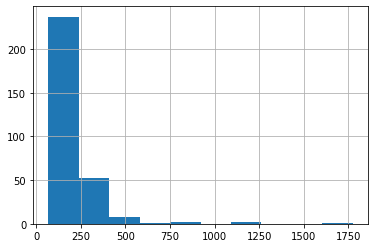

In [13]:
sdf['amount'].hist()

In [14]:
sdf.describe()

,guests,bedrooms,beds,bathrooms,starRating,amount,cleaning_fee
count,303.000000,302.000000,301.000000,303.000000,272.000000,303.000000,303.000000
mean,2.986799,1.132450,1.584718,1.240924,4.812978,205.801980,11.019802
std,1.271109,0.560914,0.881457,0.408569,0.157305,161.019209,8.998138
min,1.000000,0.000000,0.000000,1.000000,4.000000,68.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,4.717500,125.000000,5.000000
50%,3.000000,1.000000,1.000000,1.000000,4.840000,169.000000,10.000000
75%,4.000000,1.000000,2.000000,1.500000,4.930000,227.000000,15.000000
max,10.000000,4.000000,7.000000,3.500000,5.000000,1775.000000,48.000000


In [ ]:
# stays = listings['niobeClientData']['__niobe_denormalized']['queries'][0][1]['dora']['exploreV3']['sections'][1]['items']
# len(stays)

In [ ]:
# stay_dict = defaultdict(list)
# for stay in stays:
#     stay_dict['guests'].append(stay['listing']['personCapacity'])
#     stay_dict['bedrooms'].append(stay['listing']['bedrooms'])
#     stay_dict['beds'].append(stay['listing']['beds'])
#     stay_dict['bathrooms'].append(stay['listing']['bathrooms'])
#     stay_dict['sid'].append(stay['listing']['id'])
#     stay_dict['amenities'].append(stay['listing']['amenityIds'])
#     stay_dict['superhost'].append(stay['listing']['isSuperhost'])
#     stay_dict['starRating'].append(stay['listing']['avgRating'])
#     stay_dict['amount'].append(stay['pricingQuote']['price']['total']['amount'])
#     stay_dict['cleaning_fee'].append(get_cleaning_fee(stay['pricingQuote']['price']['priceItems']))

In [ ]:
for key, value in listings.items():
    print(key, len(value))

In [ ]:
1 / 0

In [ ]:
list(filter(filter_cleaning_fee, stays[0]['pricingQuote']['price']['priceItems']))[0]['total']['amount']

In [ ]:
soup = BeautifulSoup(driver.page_source)
soup.select('script#data-state')

In [ ]:
# JSON {}
# niobeClinetData
# __niobe_denormalized {}
# 0 []
# 1 {}
# dora {}
# ExplorerV3
# sections []
# 1 {}
# Items

In [ ]:
def get_stays_on_page(page_source):
    """Use BeautifulSoup to extract the stays on a page. Airbnb uses a json object
    that contains much of the desired information."""
    soup = BeautifulSoup(PageSourceURL)
    js = soup.select('script#data-state')
    listings = json.loads(js[0].string)